In [1]:
from pathlib import Path
import torch
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import os
from pathlib import Path

import cv2
import numpy as np

from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
# from deoxys.utils import RobotStateRawObsDictGenerator, YamlConfig
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger


from threading import Thread
import time

from collections import OrderedDict

import torch


from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Sep 21 2024 19:35:50


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# pretrained_policy_path=Path("/home/franka_deoxys/data_franka/imgsd_demo_bell/policy_dp/checkpoint_50000.pt")
# pretrained_policy_path=Path("/home/franka_deoxys/data_franka/imgsd_demo_bell/policy_dp/checkpoint_100000.pt")  #worked, once

# pretrained_policy_path=Path("/home/franka_deoxys/data_franka/imgsd_demo_bell/policy_dp/checkpoint_80000.pt")
# pretrained_policy_path=Path("/home/franka_deoxys/data_franka/imgsd_demo_bell/policy_dp/checkpoint_60000.pt")

pretrained_policy_path=Path("/home/franka_deoxys/data_franka/lerobot_policy/bell_oma/checkpoint_50000.pt")



policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)


delta_obs = [-0.1, 0.0]                       #50k
# delta_obs = [-0.4, 0.3, -0.1, 0.0]            #100k
delta_obs = [-0.3, 0.2, -0.1, 0.0]            #100k
# delta_obs = [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, 0.2, -0.1, 0.0]            #1800k
 
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.images.agentview_rgb": delta_obs,
    "observation.images.eye_in_hand_rgb": delta_obs,
    "observation.state": delta_obs,
    "observation.joint_states": delta_obs,
    "observation.gripper_states": delta_obs, 
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
} 

Loading weights from local directory


In [4]:
# input_shapes = {'observation.images.agentview_rgb': (3, 128, 128), 
#                 'observation.images.eye_in_hand_rgb': (3, 128, 128), 
#                 'observation.state': (16,), 
#                 'observation.gripper_states': (1,),
#                 'observation.joint_states': (7,)
#                 }

input_shapes = {'observation.images.agentview_rgb': (3, 224, 224), 
                'observation.images.eye_in_hand_rgb': (3, 224, 224), 
                'observation.state': (16,), 
                'observation.gripper_states': (1,),
                'observation.joint_states': (7,)
                }
output_shapes = {'action': (7,)}

In [5]:
class BaseRawObsDictGenerator:
    def __init__(self, *args, **kwargs):
        self.last_obs_dict = None

    def get_raw_obs_dict(self, state_info):
        """
        Args:
           state_info (dict): A dictionary of robot state + images
        """
        obs_dict = {}
        raise NotImplementedError

    def load(self):
        raise NotImplementedError


class RobotStateRawObsDictGenerator(BaseRawObsDictGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def load(self, obs_dict, key, value, check_valid=True):
        """
        This is to check if the data is correct or not. Sometimes the data will be all zero depending on the networking conditions.
        """
        if (
            (
                np.sum(np.abs(value)) == 0.0
                and key in ["ee_states", "joint_states", "gripper_states"]
            )
            and check_valid
            and self.last_obs_dict is not None
        ):
            value = self.last_obs_dict[key]
        obs_dict[key] = value

    def get_raw_obs_dict(self, state_info):
        last_state = state_info["last_state"]
        last_gripper_state = state_info["last_gripper_state"]
        obs_dict = {}

        ee_states = np.array(last_state.O_T_EE)
        joint_states = np.array(last_state.q)
        gripper_states = np.array([last_gripper_state.width])

        self.load(obs_dict, "ee_states", ee_states)
        self.load(obs_dict, "joint_states", joint_states)
        # Gripper widh will probably become zero
        self.load(obs_dict, "gripper_states", gripper_states, check_valid=False)

        for state in ["ee_states", "joint_states", "gripper_states"]:
            if (
                np.sum(np.abs(obs_dict[state])) <= 1e-6
                and self.last_obs_dict is not None
            ):
                print(f"{state} missing!!!!")
                obs_dict[state] = self.last_obs_dict[state]
        self.last_obs_dict = obs_dict
        return obs_dict

In [6]:
logger.warn("This is a very dummy control policy!!!!!")

args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

spacemouse = SpaceMouse(vendor_id=9583, product_id=50734)
spacemouse.start_control()

raw_obs_dict_generator = RobotStateRawObsDictGenerator()

import time

time.sleep(0.3)
dummy_torch_model = torch.nn.Linear(7, 1)

[Deoxys Examples WARNING] This is a very dummy control policy!!!!! (Ln 1)


/tmp/ipykernel_121672/2597759035.py:1: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("This is a very dummy control policy!!!!!")


Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: SpaceMouse Wireless

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [7]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

In [8]:
# logger.info("Resetting to the initial configuration")
# reset_joints_to(robot_interface, joint_sequence[0])
# set_gripper(open=True)

In [9]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=True, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True True
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True True


In [10]:
def get_imgs():
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]
        depth_img = imgs["depth"]

        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))

        color_img = cv2.resize(color_img, (224, 224))  
        depth_img = cv2.resize(depth_img, (224, 224))

        data[f"camera_{camera_id}_color"]=color_img
        data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [11]:
data = get_imgs()
data.keys()

dict_keys(['camera_0', 'camera_0_color', 'camera_0_depth', 'camera_1', 'camera_1_color', 'camera_1_depth'])

In [12]:
data = get_imgs()
img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

((224, 224, 3), (224, 224, 3))

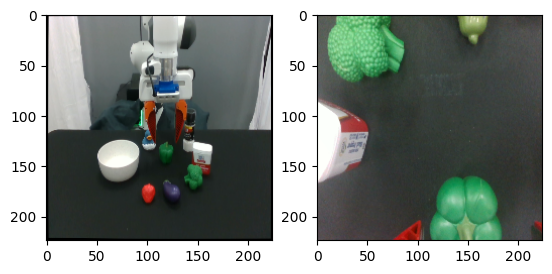

In [13]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [14]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]

    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [15]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 224, 224)
eye_in_hand_rgb (1, 3, 224, 224)


In [16]:
def env_obs_to_input(obs): 
    input_obs = {
        'observation.images.agentview_rgb': obs['agentview_rgb'],
        'observation.images.eye_in_hand_rgb': obs['eye_in_hand_rgb'],
        'observation.state': obs['ee_states'],
        'observation.gripper_states': obs['gripper_states'],
        'observation.joint_states': obs['joint_states'],
    }
    for key in input_obs.keys():
        input_obs[key] = input_obs[key][None,:]
    return input_obs

In [17]:
def predict(obs):
    row={k:torch.tensor(v).float() for k,v in obs.items()}
    input_batch = {k: v.to(device) for k, v in row.items() if k in input_shapes} 
    output_dict = policy.select_action(input_batch)
    action=output_dict.detach().cpu().numpy()
    return action

In [18]:
policy.reset()

In [19]:
obs_dict=get_current_obs(robot_interface)
obs = env_obs_to_input(obs_dict)
ac=predict(obs)
ac 

array([[ 0.124, -0.017, -0.011, -0.001, -0.001, -0.001, -0.999]],
      dtype=float32)

In [20]:
controller_type

'OSC_POSE'

In [23]:
policy.reset()
actions=[]

for _ in range(500):
    action, grasp = input2action(
        device=spacemouse,
        controller_type=controller_type,
    )
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_dict=get_current_obs(robot_interface)
    obs = env_obs_to_input(obs_dict)
    action=predict(obs)[0]


    # for key in obs_t.keys():
    #     obs_t[key]=obs_t[key][None]
    # ob2 = policy._prepare_observation(obs_t)
    # ac = policy.policy.get_action(obs_dict=ob2, goal_dict=None)
    # action=ac.detach().cpu().numpy()[0]
    actions.append(action)

    # print(f'actions: {action[0]:.3f} {action[1]:.3f} {action[2]:.3f} {action[-1]:.3f}')
    
    robot_interface.control(
        controller_type=controller_type,
        action=action,
        controller_cfg=controller_cfg,
    )

    time.sleep(0.045)

    
robot_interface.close()

In [22]:
actions

[array([ 0.156, -0.012, -0.011, -0.001, -0.001, -0.001, -1.   ],
       dtype=float32),
 array([ 0.186, -0.015, -0.01 , -0.001, -0.003, -0.001, -1.   ],
       dtype=float32),
 array([ 0.174, -0.012, -0.008, -0.   , -0.003, -0.   , -0.999],
       dtype=float32),
 array([ 0.148, -0.012, -0.003, -0.   , -0.003, -0.001, -1.   ],
       dtype=float32),
 array([ 0.149, -0.009,  0.001, -0.002, -0.001, -0.001, -0.999],
       dtype=float32),
 array([ 0.108, -0.01 ,  0.004, -0.002, -0.002, -0.001, -0.999],
       dtype=float32),
 array([ 0.126, -0.012,  0.004, -0.002, -0.002,  0.001, -1.   ],
       dtype=float32),
 array([ 0.199, -0.009, -0.007, -0.003, -0.007, -0.   , -1.   ],
       dtype=float32),
 array([ 0.002, -0.   , -0.001, -0.001, -0.001, -0.001, -0.999],
       dtype=float32),
 array([ 0.002, -0.001,  0.004, -0.   , -0.003, -0.001, -0.995],
       dtype=float32),
 array([ 0.001,  0.002, -0.008, -0.002, -0.009, -0.   , -1.   ],
       dtype=float32),
 array([-0.004,  0.008, -0.007, 